In [1]:
import pandas as pd
from datetime import timedelta
from IPython.display import HTML, display

In [2]:
date = pd.datetime.today() - timedelta(days=30)
org = 'jupyterhub'
repo = 'zero-to-jupyterhub-k8s'

In [3]:
# Make sure date is parsed as a date
date = pd.to_datetime(date)

## Comment and commit activity

This report shows general comment and commit activity for this repository. It's goal is
to give a birds-eye view of where activity is happening across the JupyterHub repositories.
It shouldn't be treated as a "leaderboard" or set of statistics to optimize for.


# Imports

In [4]:
import pandas as pd
import scrapbook as sb
from subprocess import run, PIPE
from watchtower import comments_, commits_
import os.path as op
import shutil as sh
import os
import altair as alt
import scrapbook as sb

In [5]:
# Styling functions

def highlight_rows(val):
    """Highlights cells pertaining to non-members and w/ no comments"""
    disp = ''
    if val == 0 or val == "NONE":
        disp += 'background-color: #f7b7b7'
    elif val == "FIRST_TIME_CONTRIBUTOR":
        disp += 'background-color: red'
    return disp

def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

def print_html(msg):
    display(HTML('<h2 style="padding-left: 1em;">{}</h2>'.format(msg)))
    
pd.options.display.max_colwidth = 200

## Load data

In [6]:
teams = pd.read_csv('../../data/teams.csv')

comments = comments_.load_comments(org, repo).query('created_at > @date')
commits = commits_.load_commits(org, repo).dropna(subset=['author']).query('date > @date')

comments['user'] = comments['user'].map(lambda a: a['login'])
commits['user'] = commits['author'].map(lambda a: a['login'])

top_committers = commits.groupby('user').count()['html_url'].sort_values(ascending=False).reset_index().rename(columns={'html_url': 'commits'})
top_commenters = comments.groupby('user').count()['html_url'].sort_values(ascending=False).reset_index().rename(columns={'html_url': 'comments'})

# Save committers/commenters
path_data_date = '../../reports/{:%Y-%m-%d}/data'.format(date)
if not op.isdir(path_data_date):
    os.makedirs(path_data_date)
top_committers.to_csv(op.join(path_data_date, '{}_{}-top_committers.csv'.format(org, repo)), index=False)
top_commenters.to_csv(op.join(path_data_date, '{}_{}-top_commenters.csv'.format(org, repo)), index=False)

In [7]:
print_html("Total commits: {}".format(len(commits)))
print_html("Total comments: {}".format(len(comments)))

## Top committers

In [13]:
def find_association(user):
    person = teams.query('username == @user')
    if len(person) == 0:
        return 'NONE'
    else:
        # Return their team (preferring the Binder teams since they're a bit more specific)
        return person.iloc[-1]['team']
    
top_committers['association'] = top_committers['user'].map(find_association)
top_commenters['association'] = top_commenters['user'].map(find_association)

# Define the color scale we'll use to categorize people
color_scale = alt.Scale(
    domain=["red", "lead", "blue", "jupyterhub", "NONE"],
    range=["#fdbaba", "#fdbaba", "#bac5fd", "#ffbb74", "green"]
)

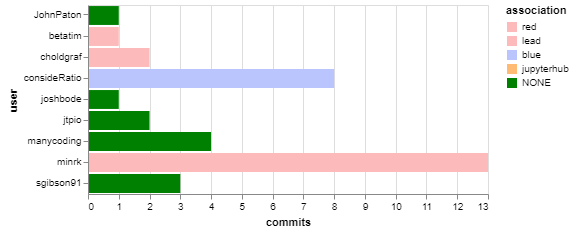

In [14]:
alt.Chart(top_committers).mark_bar().encode(
    x='commits',
    y='user',
    color=alt.Color('association', scale=color_scale)
)

## Top commenters

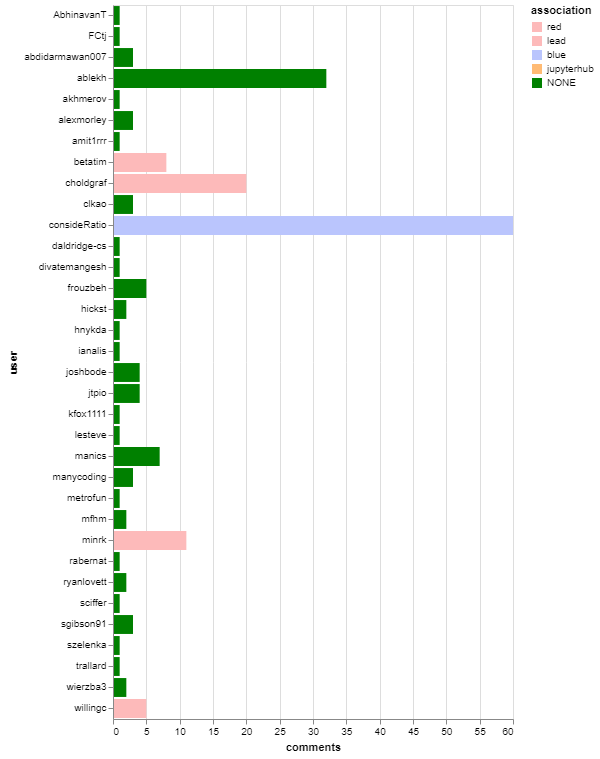

In [15]:
alt.Chart(top_commenters).mark_bar().encode(
    x='comments',
    y='user',
    color=alt.Color('association', sort=["CONTRIBUTOR", "MEMBER", "NONE"], scale=color_scale)
)

## Percentages of comments and commits

In [16]:
# Calculate percentages
sum_comments = top_commenters.groupby('association')['comments'].sum().reset_index().rename(columns={'comments': "percent"})
sum_comments['kind'] = "comments"
sum_comments['percent'] = 100*(sum_comments['percent'] / sum_comments['percent'].sum())

sum_commits = top_committers.groupby('association')['commits'].sum().reset_index().rename(columns={'commits': "percent"})
sum_commits['kind'] = "commits"
sum_commits['percent'] = 100*(sum_commits['percent'] / sum_commits['percent'].sum())

sum_both = pd.concat([sum_comments, sum_commits])

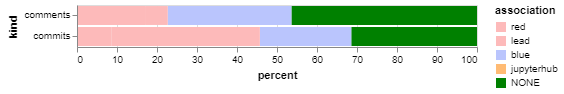

In [17]:
alt.Chart(sum_both).mark_bar().encode(
    x='percent',
    y='kind',
    color=alt.Color('association', sort=["CONTRIBUTOR", "MEMBER", "NONE"], scale=color_scale)
)